# Import dependencies 

In [1]:
from kaggle.api.kaggle_api_extended import KaggleApi
import os
import pandas as pd
import glob

api = KaggleApi()
api.authenticate()

dataset_ref = 'abhishek14398/salary-dataset-simple-linear-regression'
download_path = './data/raw'

os.makedirs(download_path, exist_ok=True)
api.dataset_download_files(dataset_ref, path=download_path, unzip=True)

Dataset URL: https://www.kaggle.com/datasets/abhishek14398/salary-dataset-simple-linear-regression


### Let's predict the salary based on the Years of Experience

# Basic EDA

In [2]:
csv_files = glob.glob(os.path.join(download_path, "*.csv"))
df = pd.read_csv(csv_files[0], index_col = 0)
df.head()

,YearsExperience,Salary
0,1.2,39344.0
1,1.4,46206.0
2,1.6,37732.0
3,2.1,43526.0
4,2.3,39892.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, 0 to 29
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   YearsExperience  30 non-null     float64
 1   Salary           30 non-null     float64
dtypes: float64(2)
memory usage: 720.0 bytes


In [4]:
print(f"The number of duplicates is {df.duplicated().sum()}")

The number of duplicates is 0


In [5]:
print(f"The unique values of each column are:")
print(df.nunique(dropna=False))

The unique values of each column are:
YearsExperience    28
Salary             30
dtype: int64


In [6]:
print("The columns with duplicates are:\n")
print(df[df.YearsExperience.duplicated(keep=False)])

The columns with duplicates are:

    YearsExperience   Salary
7               3.3  54446.0
8               3.3  64446.0
11              4.1  55795.0
12              4.1  56958.0


Target variable is continuous and we need explainability so we will go for Linear Regression

- Size is 30 entries and 2 columns. 
- Nulls = 0
- Duplicates = 2 but they don't show any clear pattern

## Visualization

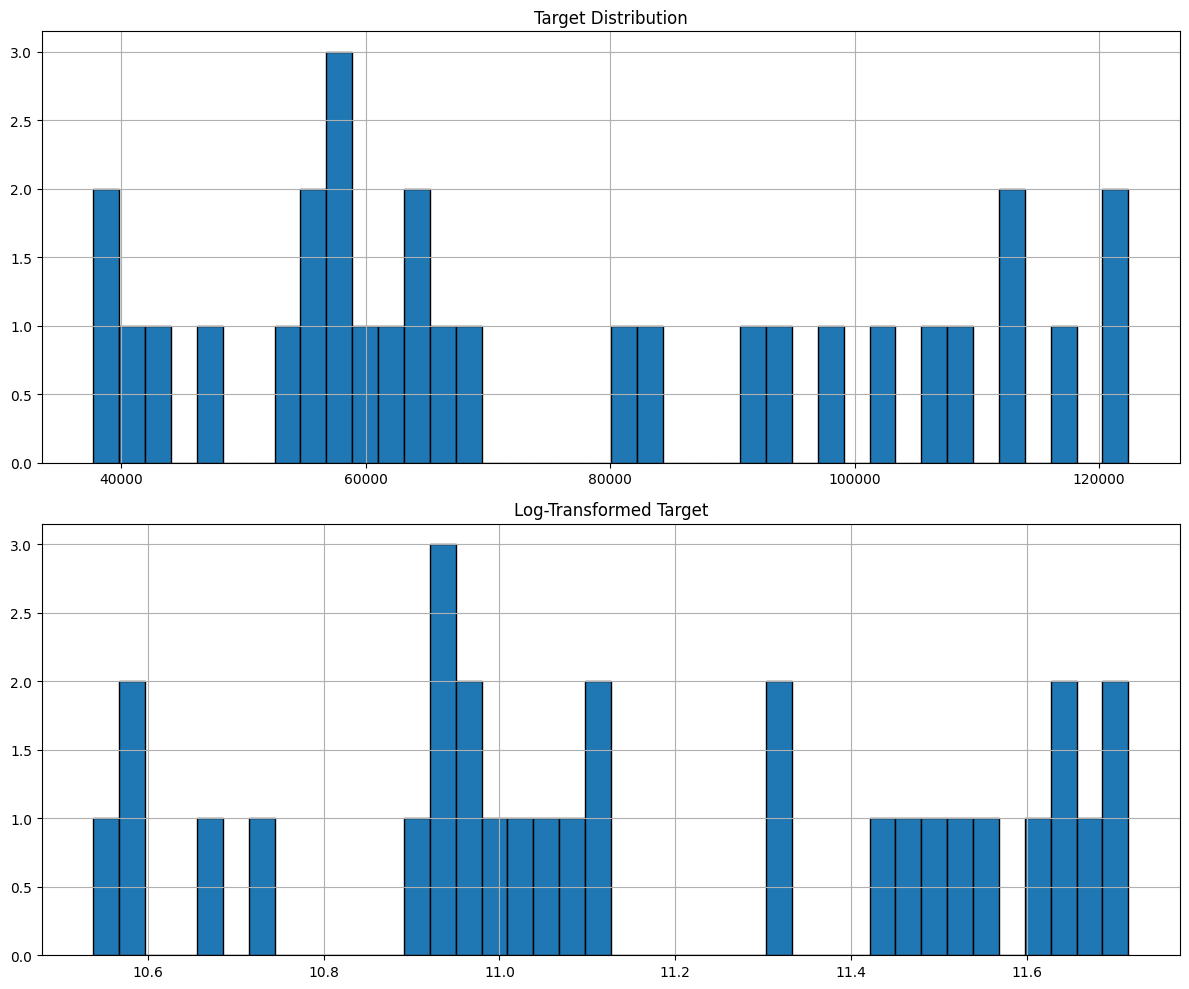

Skewness: 0.34
Kurtosis: -1.28


In [7]:
import numpy as np
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt

y = df['Salary']

fig, ax = plt.subplots(figsize=(12, 5))
ax.hist(y, bins=40, edgecolor='k')
ax.set_title('Target Distribution')
ax.grid(True)
plt.tight_layout()
plt.show()


print(f"Skewness: {skew(y):.2f}")
print(f"Kurtosis: {kurtosis(y):.2f}")

Skewness is roughly symmetric (< 0.5) I will leave it as it is
Kurtosis is negative (platykurtic) so I will leave it as it is too

In [ ]:
# outliers
from scipy import stats

X = df["YearsExperience"]
z_scores = np.abs(stats.zscore(X))
outlier_rows = (z_scores > 3)
print(f"Outlier rows (Z > 3): {outlier_rows.sum()} / {len(X)}")

Outlier rows (Z > 3): 0 / 30


No outliers

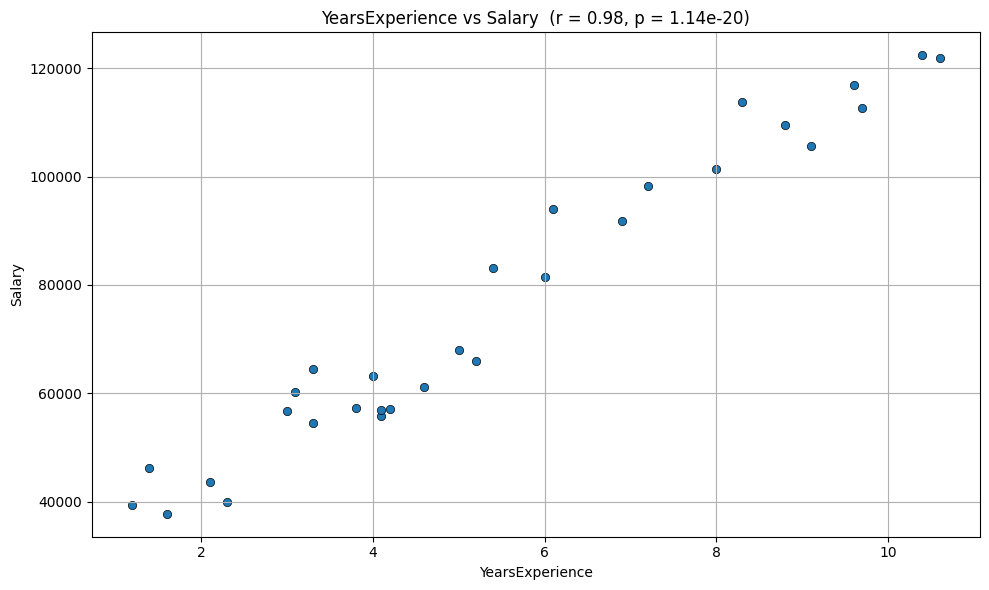

In [ ]:
# correlation and relationship between feature and target
import seaborn as sns
from scipy.stats import pearsonr

r, p_value = pearsonr(X, y)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X, y=y, edgecolor='k', alpha=1)
plt.title(f'YearsExperience vs Salary  (r = {r:.2f}, p = {p_value:.2e})')
plt.xlabel('YearsExperience')
plt.ylabel('Salary')
plt.grid(True)
plt.tight_layout()
plt.show()

- r close to 1, strong linear relationship
- p-value : less than 0.05 so the correlation is statistically significant

In [10]:
# Split the data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Linear Regression

In this case since our dataset is extremely small we can use the Normal Equation 

Training set: 24 samples
Test set: 6 samples


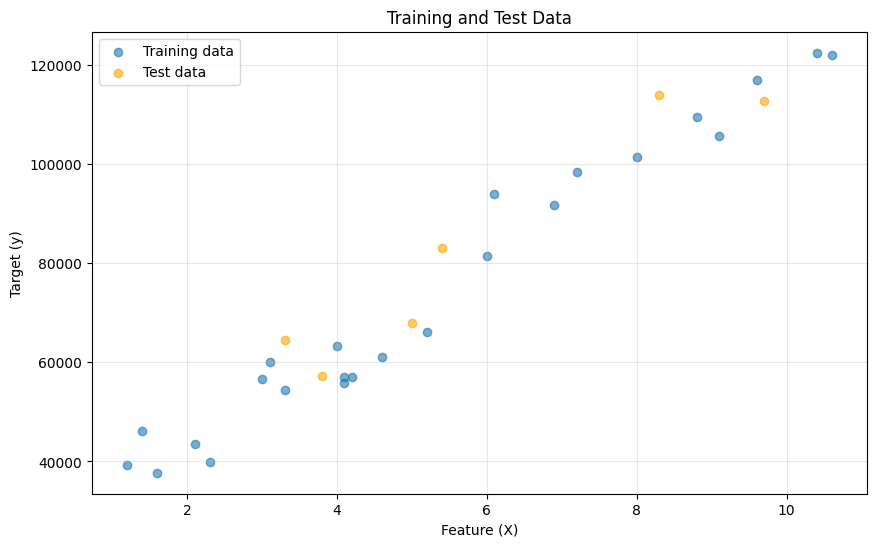

In [11]:

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Visualize the data
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, alpha=0.6, label='Training data')
plt.scatter(X_test, y_test, alpha=0.6, color='orange', label='Test data')
plt.xlabel('Feature (X)')
plt.ylabel('Target (y)')
plt.title('Training and Test Data')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [12]:
# --- Linear Regression (Normal Equation via sklearn) ---
from sklearn.linear_model import LinearRegression

X_train_arr = X_train.values.reshape(-1, 1)
X_test_arr = X_test.values.reshape(-1, 1)

model = LinearRegression()
model.fit(X_train_arr, y_train)

print(f"Linear Regression results:")
print(f"  Intercept: {model.intercept_:.4f}")
print(f"  Slope:     {model.coef_[0]:.4f}")

Linear Regression results:
  Intercept: 24380.2015
  Slope:     9423.8153


In [13]:
# --- Training performance baseline ---
from sklearn.metrics import mean_squared_error, r2_score

y_train_pred = model.predict(X_train_arr)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Training R²:   {train_r2:.4f}")

Training RMSE: 5205.9821
Training R²:   0.9645


## Validate Assumptions

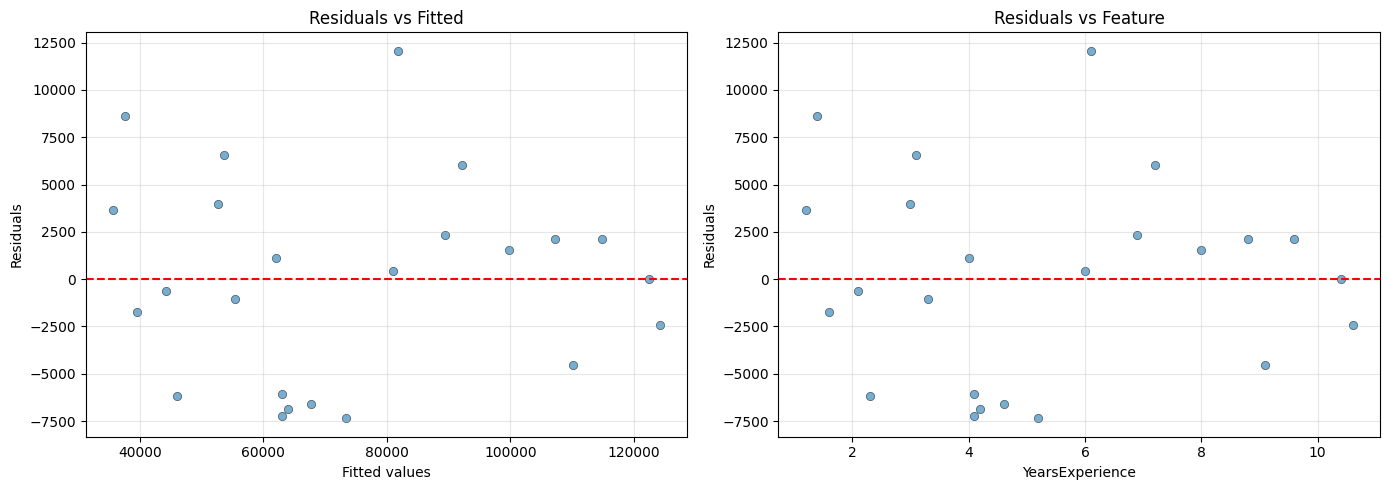

In [14]:
# --- 1. Check Linearity (Residuals vs Fitted) ---

residuals = y_train.values - y_train_pred

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(y_train_pred, residuals, alpha=0.6, edgecolors='k', linewidths=0.5)
axes[0].axhline(y=0, color='r', linestyle='--')
axes[0].set_xlabel('Fitted values')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residuals vs Fitted')
axes[0].grid(True, alpha=0.3)

axes[1].scatter(X_train, residuals, alpha=0.6, edgecolors='k', linewidths=0.5)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_xlabel('YearsExperience')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residuals vs Feature')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [15]:
# --- 2. Check Independence (Durbin-Watson) ---
from statsmodels.stats.stattools import durbin_watson

dw = durbin_watson(residuals)
print(f"Durbin-Watson: {dw:.2f}")
print("  (1.5-2.5 = no significant autocorrelation)")

Durbin-Watson: 2.03
  (1.5-2.5 = no significant autocorrelation)


In [16]:
# --- 3. Check Homoscedasticity (Breusch-Pagan) ---
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm

X_with_const = sm.add_constant(X_train_arr)
bp_test = het_breuschpagan(residuals, X_with_const)
labels = ['LM Statistic', 'LM p-value', 'F Statistic', 'F p-value']
for label, val in zip(labels, bp_test):
    print(f"  {label}: {val:.4f}")

bp_pvalue = bp_test[1]
if bp_pvalue > 0.05:
    print("\n  -> p-value > 0.05: Homoscedasticity holds.")
else:
    print("\n  -> p-value < 0.05: Heteroscedasticity detected. Consider log(y) or WLS.")

  LM Statistic: 0.9309
  LM p-value: 0.3346
  F Statistic: 0.8877
  F p-value: 0.3563

  -> p-value > 0.05: Homoscedasticity holds.


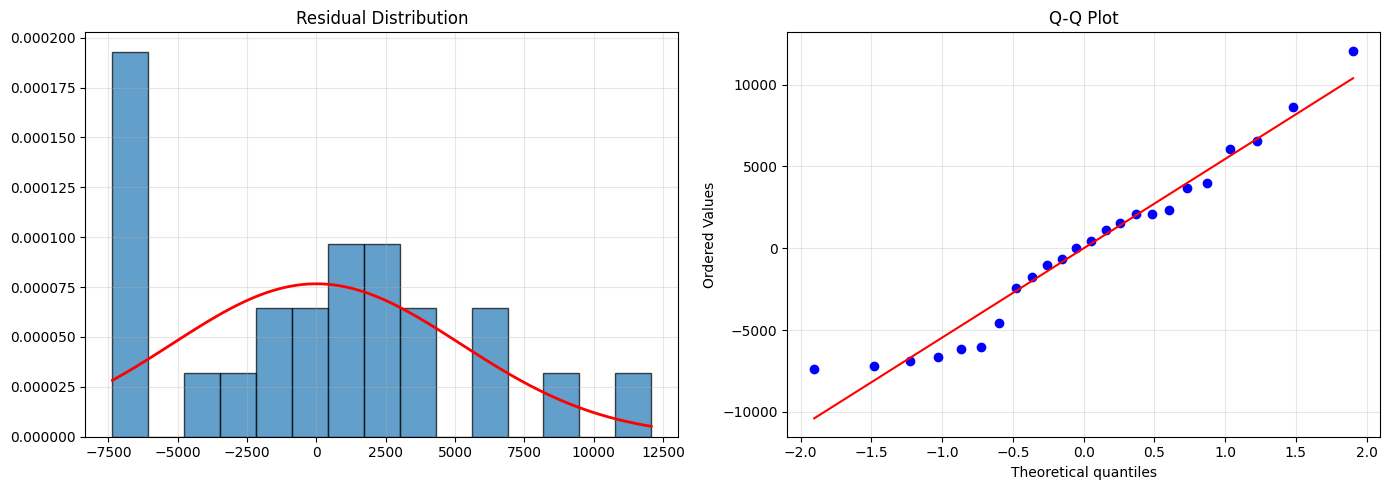

Shapiro-Wilk: stat=0.9534, p=0.3200
  -> p > 0.05: Normality assumption holds.


In [17]:
# --- 4. Check Normality of Residuals ---

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(residuals, bins=15, edgecolor='k', alpha=0.7, density=True)
x_range = np.linspace(residuals.min(), residuals.max(), 100)
axes[0].plot(x_range, stats.norm.pdf(x_range, residuals.mean(), residuals.std()), 'r-', lw=2)
axes[0].set_title('Residual Distribution')
axes[0].grid(True, alpha=0.3)

stats.probplot(residuals, plot=axes[1])
axes[1].set_title('Q-Q Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

if len(residuals) < 5000:
    stat, p_val = stats.shapiro(residuals)
    print(f"Shapiro-Wilk: stat={stat:.4f}, p={p_val:.4f}")
    if p_val > 0.05:
        print("  -> p > 0.05: Normality assumption holds.")
    else:
        print(f"  -> p < 0.05: Normality assumption violated, but n={len(residuals)} > 30 may allow CLT." if len(residuals) > 30 else "  -> p < 0.05: Normality violated and n is small. Consider transforming y.")

## Evaluate Performance

In [18]:
# --- Test set metrics ---
from sklearn.metrics import mean_absolute_error

y_test_pred = model.predict(X_test_arr)

test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

n_samples = X_test_arr.shape[0]
n_features = X_test_arr.shape[1]
adj_r2 = 1 - (1 - test_r2) * (n_samples - 1) / (n_samples - n_features - 1)

print(f"Test RMSE:     {test_rmse:.4f}")
print(f"Test MAE:      {test_mae:.4f}")
print(f"Test R²:       {test_r2:.4f}")
print(f"Adjusted R²:   {adj_r2:.4f}")

print(f"\nTraining R²:   {train_r2:.4f}")
print(f"Test R²:       {test_r2:.4f}")
print(f"Gap:           {abs(train_r2 - test_r2):.4f}")

Test RMSE:     7059.0436
Test MAE:      6286.4538
Test R²:       0.9024
Adjusted R²:   0.8781

Training R²:   0.9645
Test R²:       0.9024
Gap:           0.0621


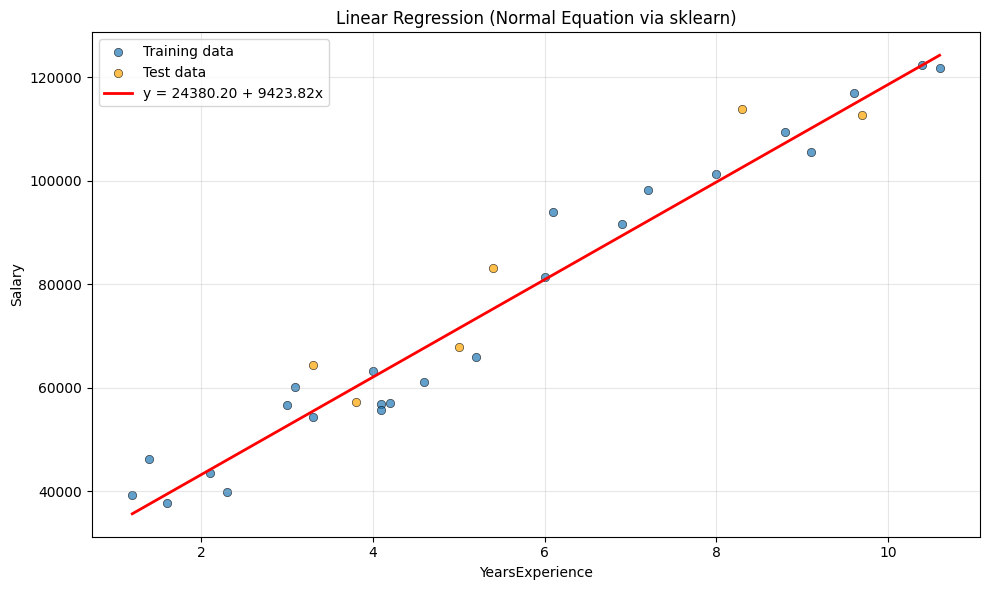

In [19]:
# --- Final visualization: regression line ---

x_line = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_line = model.predict(x_line)

plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, alpha=0.7, label='Training data', edgecolors='k', linewidths=0.5)
plt.scatter(X_test, y_test, alpha=0.7, color='orange', label='Test data', edgecolors='k', linewidths=0.5)
plt.plot(x_line, y_line, 'r-', linewidth=2, label=f'y = {model.intercept_:.2f} + {model.coef_[0]:.2f}x')
plt.xlabel('YearsExperience')
plt.ylabel('Salary')
plt.title('Linear Regression (Normal Equation via sklearn)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()